# Overview
In this notebook, I predict the price of a used vehicle.

Submissions are scored on the root mean squared error. 

For each id in the test set, the price of the car is predicted. 

# Data Collection

The dataset for this competition (both train and test) was generated from a deep learning model fine-tuned on the Used Car Price Prediction Dataset dataset. 


*  **id**            : The id associated with the car.
*  **brand**         : Brand or company name.
*  **model**         : Specific model.
*  **model_year**    : Year of manufacturing.
*  **milage**        : The mileage of each vehicle.
*  **fuel_type**     : Type of fuel the vehicles run on. (gasoline, diesel, electric, or hybrid)
*  **engine**        : Type of engine.
*  **transmission**  : The transmission type. (Automatic / Manual)
*  **ext_col**       : Exterior color.
*  **int_col**       : Interior color.
*  **accident**      : Accident history.
*  **clean_title**   : A clean title tells you a vehicle has never been declared a total loss.
*  **price**         : Price listed by the seller.



## Install Libraries and Load Dataset

In [1]:
# Install libraries
!pip install -U scikit-learn
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from scipy.sparse import hstack

from matplotlib.ticker import ScalarFormatter


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Load data
train = pd.read_csv("/kaggle/input/d/njeanette/kagglex-cohort4/kagglex-cohort4/train.csv")
test = pd.read_csv("/kaggle/input/d/njeanette/kagglex-cohort4/kagglex-cohort4/test.csv")
submission = pd.read_csv("/kaggle/input/d/njeanette/kagglex-cohort4/kagglex-cohort4/sample_submission.csv")

## Data Exploration

I explore the data to understand the various columns and how useful each columns is. Observations include 13 columns, which some may need to be converted to different and appropriate dtypes:

**Numerical**: id, model_year, milage, and price (in test dataset only).

**Categorical**: brand, model, fuel_type, engine, transmission, ext_col, int_col, accident, and clean_title.

We will use the column 'id' to predict our target variable 'price'.

Categorical columns will need to be converted to dummy variables before being used in our model.


In [4]:
# Check data shape
train.shape

(54273, 13)

In [5]:
test.shape

(36183, 12)

In [6]:
# Check duplicates
train.duplicated().sum()

0

In [7]:
# Check data types
# Print out different data types

# Categorical columns
cat_col = [col for col in train.columns if train[col].dtype == 'object']
print('Categorical columns: ',cat_col)
# Numerical columns
num_col = [col for col in train.columns if train[col].dtype != 'object']
print('Numerical columns: ',num_col)

Categorical columns:  ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical columns:  ['id', 'model_year', 'milage', 'price']


In [8]:
# Print out different data types

# Categorical columns
cat_col = [col for col in test.columns if test[col].dtype == 'object']
print('Categorical columns: ',cat_col)
# Numerical columns
num_col = [col for col in test.columns if test[col].dtype != 'object']
print('Numerical columns: ',num_col)

Categorical columns:  ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical columns:  ['id', 'model_year', 'milage']


In [9]:
# Look at data
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [10]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes


In [11]:
# Look at missing data
train.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [12]:
test.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [13]:
# Summary statistics of numerical variables
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,54273.0,27136.000000,15667.409917,0.0,13568.0,27136.0,40704.0,54272.0
model_year,54273.0,2015.091979,5.588909,1974.0,2012.0,2016.0,2019.0,2024.0
milage,54273.0,72746.175667,50469.490448,100.0,32268.0,66107.0,102000.0,405000.0
price,54273.0,39218.443333,72826.335535,2000.0,15500.0,28000.0,45000.0,2954083.0


In [14]:
# Summary statistics of categorical variables
train.describe(include=['object']).T

,count,unique,top,freq
brand,54273,53,BMW,7369
model,54273,1827,F-150 XLT,780
fuel_type,54273,7,Gasoline,49439
engine,54273,1061,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,1452
transmission,54273,46,A/T,16757
ext_col,54273,260,Black,15078
int_col,54273,124,Black,31820
accident,54273,2,None reported,39896
clean_title,54273,1,Yes,54273


Observations and Insights: 

**model_year** tells us that we have cars manufactured as old as 1996 to as new as 2024.
The 25% mark tells us that only 25% of cars are the ones that were manufactured before 2012. 

**milage** has a min value of 100 miles to a max value of 405000 miles driven. The average miles driven for a car is 66107 miles.

**price**, which is found in the training dataset only, will be used to help train the model to predict car prices and tested on the test dataset. Car prices range from as low as 2000 to as high as 2,954,083. 

## ID
For each id in the test set, I use to predict the price of the car. I check if id is all unique and matches number of rows in dataset. It is indeed all unique.

In [15]:
len(train) == len(train['id'].unique())

True

## Brand
I explore the various brands of cars in the dataset. 

Observations:

There are brands in the test dataset not found in the train dataset: smart and Saab. I will add 'unknown' category in the training set for handling new brands in the feature engineering section. 

At first, I thought smart was a typo, but it is purposefully stylized in lowercase, so I leave it be.

BMW, Ford, and Mercedes-Benz are the most popular car brands.

However, the most expensive cars on average by brand are Bugatti, followed by Ferrari, and Lamborghini. The least expensive cars on average by brand are Plymouth, Suzuki, and Scion. 

In [16]:
train['brand'].value_counts()

brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             27
Merc

In [17]:
test['brand'].value_counts()

brand
BMW              4854
Ford             4382
Mercedes-Benz    3265
Chevrolet        2993
Audi             1919
Porsche          1805
Toyota           1574
Lexus            1530
Jeep             1510
Land             1360
Cadillac         1059
Nissan            922
GMC               749
Dodge             705
INFINITI          666
RAM               606
Mazda             528
Lincoln           496
Subaru            492
Jaguar            447
Hyundai           436
Honda             405
Acura             386
Volkswagen        376
Kia               347
Volvo             309
MINI              258
Maserati          182
Bentley           180
Chrysler          178
Genesis           173
Buick             165
Hummer            118
Mitsubishi        114
Pontiac           109
Lamborghini        91
Rolls-Royce        89
Alfa               79
Tesla              71
Ferrari            52
Aston              44
Saturn             36
Scion              34
McLaren            30
Rivian             22
Lotu

In [18]:
# Identify unique brands in training and test sets
train_brands = set(train['brand'])
test_brands = set(test['brand'])

# Find new brands in the test set not present in the training set
new_brands = test_brands - train_brands

print("New brands in the test set:", new_brands)

New brands in the test set: {'Saab', 'smart'}


In [19]:
# Average price of car by brand
average_price = train.groupby(['brand'])['price'].mean().sort_values(ascending=False)

# Print each brand and its average price without scientific notation
for brand, price in average_price.items():
    print(f'{brand}: {price:,.2f}')

Bugatti: 1,950,995.00
Ferrari: 158,404.33
Lamborghini: 144,773.86
Rolls-Royce: 131,365.08
Aston: 117,885.82
McLaren: 109,174.77
Bentley: 105,211.79
Lucid: 84,185.00
Rivian: 79,495.81
Porsche: 63,742.15
Maybach: 60,333.33
Maserati: 56,872.70
Genesis: 51,462.40
Tesla: 49,056.66
Land: 47,714.27
Mercedes-Benz: 47,094.04
Alfa: 45,712.24
RAM: 45,126.19
Chevrolet: 44,751.11
GMC: 41,570.95
BMW: 40,276.03
Lotus: 38,456.58
Ford: 38,154.06
Audi: 37,091.37
Cadillac: 36,575.84
Jaguar: 34,840.40
Jeep: 30,703.34
Lexus: 30,685.44
Hummer: 30,578.99
INFINITI: 29,694.08
Kia: 29,087.56
Toyota: 29,080.00
Dodge: 28,938.06
Acura: 27,899.55
Lincoln: 27,733.62
Volvo: 27,693.74
Buick: 27,693.25
Mazda: 24,223.28
Nissan: 23,874.30
Volkswagen: 22,603.02
Subaru: 22,505.88
Chrysler: 19,518.67
Hyundai: 18,931.53
Honda: 18,568.90
Pontiac: 17,526.06
MINI: 16,055.87
Mercury: 14,561.80
FIAT: 14,183.88
Saturn: 13,733.40
Mitsubishi: 13,434.54
Scion: 12,939.53
Suzuki: 11,099.75
Plymouth: 3,850.00


## Model
I explore the various models of cars in the dataset.

There are lots of models in the test dataset not found in the train dataset. I will add 'other' category in the training set for handling new models in the feature engineering section as opposed to dropping them.

Because car models affect its price, I want to include them in the data. Therefore, by mapping new models to existing similar models in an 'other' category, it can help generalize unseen data without significantly compromising its predictive performance.

The most expensive car model on average is Veyron 16.4 Grand Sport at 1,950,995.00 USD. The lowest priced car model on average is Prowler Base at 3,850.00 USD.

In [20]:
train['model'].value_counts()

model
F-150 XLT             780
M3 Base               682
X5 xDrive35i          615
F-150 Lariat          496
Mustang GT Premium    466
                     ... 
Suburban 2500           1
TLX Tech                1
Rogue Sport S           1
A8 4.0                  1
S-10 LS                 1
Name: count, Length: 1827, dtype: int64

In [21]:
test['model'].value_counts()

model
F-150 XLT                    496
M3 Base                      444
X5 xDrive35i                 390
F-150 Lariat                 329
Camaro 2SS                   299
                            ... 
AMG GLE 53 AMG GLE 53          1
Sorento Plug-In Hybrid SX      1
RLX Advance Package            1
Model S 85D                    1
Model 3 Mid Range              1
Name: count, Length: 1791, dtype: int64

In [22]:
# Identify unique models in training and test sets
train_models = set(train['model'])
test_models = set(test['model'])

# Find new brands in the test set not present in the training set
new_models = test_models - train_models

print("New brands in the test set:", new_models)

New brands in the test set: {'Q3 S line Premium Plus', 'AMG E 53 4MATIC', 'Tucson Hybrid SEL Convenience', 'ForTwo Pure', 'Passport Elite', 'IONIQ 5 SE', 'RS 7 4.0T quattro', 'Model S 70D', 'R1T Launch Edition', 'TLX w/A-Spec Package', 'G-Class G 550', 'GLE 350 Base', 'Ram 2500 SLT Mega Cab', '4Runner Venture Special Edition', 'Passat 2.0T R-Line', 'Cherokee X', 'Leaf SL', 'F-TYPE V6 S', 'RDX w/Advance Package', 'Integra w/A-Spec Tech Package', 'Leaf SV PLUS', 'Mustang Boss 302', 'RDX', 'Model S 85', '430 Gran Coupe i xDrive', 'Wraith Base', 'X7 xDrive50i', 'Kona EV SEL', 'EV6 GT-Line', 'Model 3 Mid Range', 'Pacifica Hybrid Touring L', 'Q7 Premium Plus'}


In [23]:
# Average price of car by model
average_price_model = train.groupby(['model'])['price'].mean().sort_values(ascending=False)

# Print each brand and its average price without scientific notation
for model, price in average_price_model.items():
    print(f'{model}: {price:,.2f}')

Veyron 16.4 Grand Sport: 1,950,995.00
RDX PMC Edition: 765,815.50
R8 5.2 V10 performance: 551,153.50
Tacoma TRD Pro: 513,937.25
MC20 MC20: 489,000.00
Q5 S line Premium: 469,900.00
Sierra 1500 SL Crew Cab: 357,931.33
488 GTB Base: 301,493.60
Huracan EVO Coupe: 279,950.00
Aventador LP700-4: 279,950.00
Huracan Tecnica Coupe: 272,950.00
Phantom: 272,037.11
Phantom Drophead Coupe Drophead: 270,413.75
CT5-V Blackwing: 259,388.00
812 Superfast Base: 257,950.00
Viper GTC: 247,847.00
Countryman Cooper: 243,900.00
Sportage X-Pro: 239,995.00
Huracan EVO Base: 236,428.09
Quattroporte Modena Q4: 226,528.50
Rover Range Rover Autobiography: 222,025.33
570S Spider: 214,372.28
Rover Range Rover P530 SE: 213,697.50
Quattroporte S GranLusso: 212,420.00
Martin DBS Superleggera: 210,048.67
720S Performance: 197,056.64
Continental GT GT Speed: 194,965.00
Grecale Modena: 190,680.12
Grand Wagoneer Base: 189,229.60
Land Cruiser: 188,900.00
Carrera GT Base: 188,164.67
Silverado 1500 LTZ: 188,062.32
Bentayga Spe

## Model Year
I explore the various model years of cars in the dataset, which is crucial for assessing depreciation and technology advancements.

As a car gets older, its value typically decreases.

We have cars as old as 1974 to as new as 2024.

2019 is the year where the most cars were distributed. In 2008 and 2009, there is a small rise in distribution of cars compared to previous and followed by a dip in 2010. Upon a quick Google search, 2008-2010 is the years the automotive industry faced a crisis. Further research would be needed to see if its a confounder or of importance to take note.

Range of years: 1974 to 2024


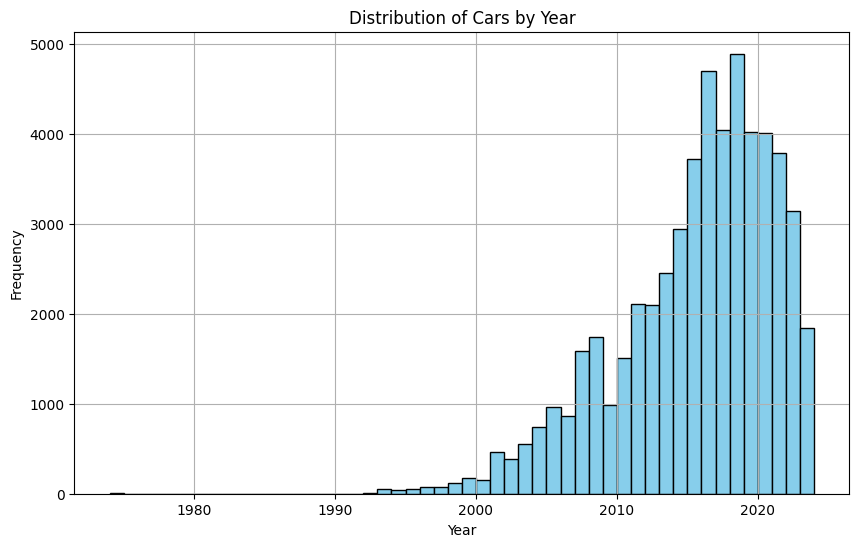

In [24]:
# Look at distribution of cars across model years
min_year = train['model_year'].min()
max_year = train['model_year'].max()
print(f"Range of years: {min_year} to {max_year}")
plt.figure(figsize=(10, 6))
plt.hist(train['model_year'], bins=range(train['model_year'].min(), train['model_year'].max() + 1), color='skyblue', edgecolor='black')
plt.title('Distribution of Cars by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Range of years: 1974 to 2024


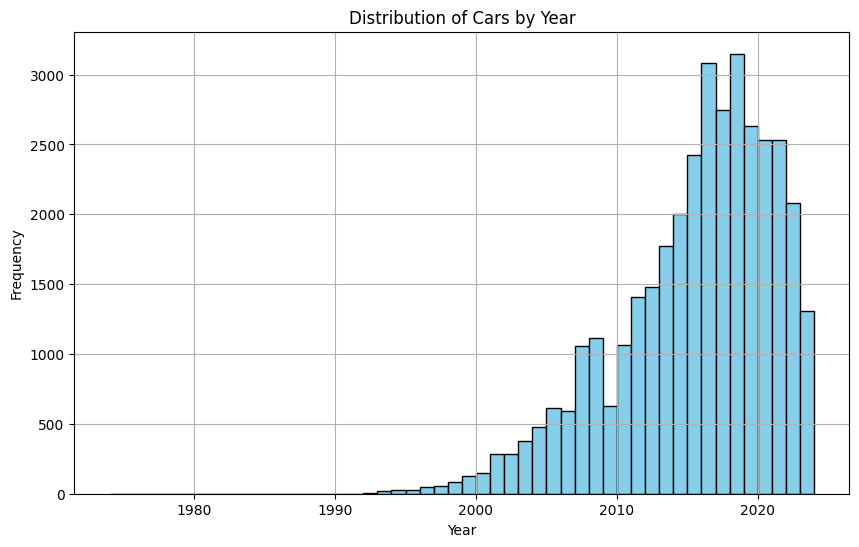

In [25]:
# Look at distribution of cars across model years
min_year = test['model_year'].min()
max_year = test['model_year'].max()
print(f"Range of years: {min_year} to {max_year}")
plt.figure(figsize=(10, 6))
plt.hist(test['model_year'], bins=range(train['model_year'].min(), test['model_year'].max() + 1), color='skyblue', edgecolor='black')
plt.title('Distribution of Cars by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Milage
I explore the various milage of each vehicle in the data, a key indicator of wear and tear and potential maintenance requirements. Milage is a factor in car depreciation. 

Milage ranges from 100 to 405,000 miles.

In [26]:
# Look at distribution of cars across model years
min_miles = train['milage'].min()
max_miles = train['milage'].max()
print(f"Range of miles: {min_miles} to {max_miles}")

Range of miles: 100 to 405000


In [27]:
min_miles = test['milage'].min()
max_miles = test['milage'].max()
print(f"Range of miles: {min_miles} to {max_miles}")

Range of miles: 100 to 405000


## Fuel Type
I explore the various fuel types the cars run on.

The majority of fuel type is Gasoline, followed by Hybrid, and then E85 Flex Fuel. 

The - and not supported fuel types will need to be replaced with Electric as fuel type.

In [28]:
train['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

In [29]:
test['fuel_type'].value_counts()

fuel_type
Gasoline          33033
Hybrid             1112
E85 Flex Fuel      1018
Diesel              671
–                   197
Plug-In Hybrid      148
not supported         4
Name: count, dtype: int64

## Engine
I explore the various engine of each vehicle in the data, which specifies the engine specifications, shedding light on performance and efficiency. 

'Engine' are strings with numerical values and the numerical values may need to be extracted for further analysis. There appears to be three possible features with numerical value in the string: horsepower(HP), engine displacement(L), and cylinders(Cylinder).

Generally, the higher/lower horsepower, engine displacement, and cylinders are correlated with a higher/lower price, respectively.


In [30]:
train['engine'].value_counts()

engine
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    1452
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             1125
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             1054
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel             979
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel              893
                                                         ... 
4.4 Liter GDI DOHC Twin Turbo                               1
3.0 Liter Twin Turbo                                        1
150.0HP 2.0L 4 Cylinder Engine Diesel Fuel                  1
266.0HP Electric Motor Electric Fuel System                 1
151.0HP Electric Motor Hydrogen Fuel                        1
Name: count, Length: 1061, dtype: int64

# Transmission
I explore the various transmission types of each vehicle in the data.

The most common transmission type appears to be Automatic. However, in the feature engineering section, I may want to group by Automatic, Manual, or CVT. 

In [31]:
train['transmission'].value_counts()

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

## Exterior Color
I explore the various exterior colors of each car in the data. 

Black is the most common color choice. Certain car colors may be more expensive. However, upon researching, each manufacturer has their own color name list and choices so no feature engineering may be needed for colors and can be dropped instead.

In [32]:
train['ext_col'].value_counts()

ext_col
Black                      15078
White                      13422
Gray                        7909
Silver                      5161
Blue                        4668
                           ...  
Balloon White                  1
Firenze Red Metallic           1
Orca Black Metallic            1
Radiant Red Metallic II        1
Magnetic Gray Clearcoat        1
Name: count, Length: 260, dtype: int64

## Interior Color
I explore the various interior colors of each car in the data. 

In [33]:
train['int_col'].value_counts()

int_col
Black                31820
Beige                 7995
Gray                  6252
Brown                 2239
Red                   1499
                     ...  
Cloud                    1
Black/Red                1
Oyster/Black             1
Oyster W/Contrast        1
Red/Black                1
Name: count, Length: 124, dtype: int64

## Accident
I explore the accident report of each car in the data. 

A car that is accident free will have a higher resale value than one that has at least 1 accident or damage reported.

In [34]:
train['accident'].value_counts()

accident
None reported                             39896
At least 1 accident or damage reported    14377
Name: count, dtype: int64

##  Clean Title
I expore the clean title of each car in the data, which tells you if a vehicle has been declared a total loss or not.

All the cars in the data have a clean title and therefore the column can be dropped as it will not be much help when building the model.

In [35]:
train['clean_title'].value_counts()

clean_title
Yes    54273
Name: count, dtype: int64

## Price
This is our target variable, and is the price of the car listed by the seller. I explore price and its relationship with other variables.

Observations: Most cars on average are priced below 1M USD. It appears that the newer the model_year, the higher the selling price. Distribution seems skewed right. There seems to be an outlier in the far left end tail.

A majority of the cars have a milage of 150,000 miles or less. It appears that the more milage the car has, the less the selling price. Distribution seems skewed left. There seems to be an outlier in the far right end tail.

In [36]:
train['price'].isnull().sum()

0

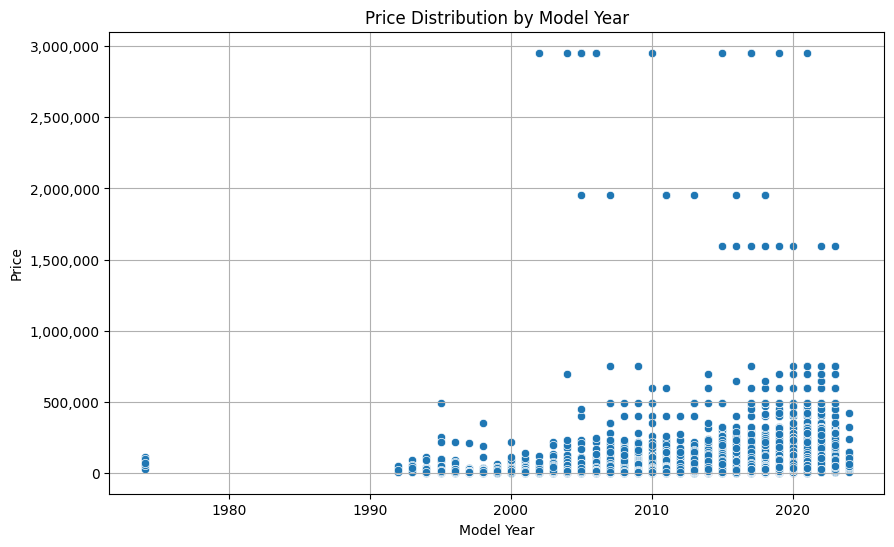

In [37]:
# Scatterplot of Relationship of price and model_year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model_year', y='price', data=train)

# Function to format y-axis without scientific notation
def custom_format(x, _):
    return '{:,.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_format))

plt.title('Price Distribution by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

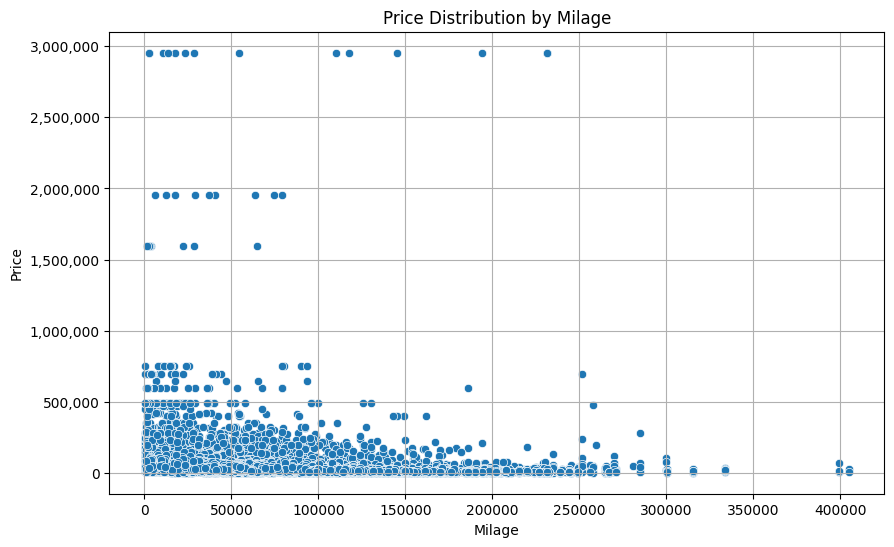

In [38]:
# Scatterplot of Relationship of price and milage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milage', y='price', data=train)

# Function to format y-axis without scientific notation
def custom_format(x, _):
    return '{:,.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_format))

plt.title('Price Distribution by Milage')
plt.xlabel('Milage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Data Preprocessing
In this step, I will drop unnecessary columns, remove outliers, and do feature engineer as necessary and label encoding for categorical variables.

In [39]:
# Drop clean_title, ext_col, and int_col columns
train.drop(['clean_title'], axis = 1, inplace = True)
train.drop(['ext_col'], axis = 1, inplace = True)
train.drop(['int_col'], axis = 1, inplace = True)
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,accident,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,None reported,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,None reported,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,None reported,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,7850


In [40]:
test.drop(['clean_title'], axis = 1, inplace = True)
test.drop(['ext_col'], axis = 1, inplace = True)
test.drop(['int_col'], axis = 1, inplace = True)
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,accident,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,None reported,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,None reported,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,None reported,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,7850


## Remove outliers

In [41]:
# From the previous scatterplot of price vs model_years, the tail left end seems to be an outlier.
# Remove data from years prior to 1990
train = train[train['model_year'] >= 1990]
test = test[test['model_year'] >= 1990]

In [42]:
# IQR
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1

# Bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = train[(train['price'] < lower_bound) | (train['price'] > upper_bound)]
print("Outliers based on IQR:")
print(outliers_iqr)

Outliers based on IQR:
          id          brand                                      model  \
10        10       Maserati                Quattroporte S Q4 GranLusso   
16        16          Tesla                         Model 3 Long Range   
19        19            Kia                               Telluride LX   
26        26           Ford                         Expedition Max XLT   
35        35       Cadillac                      Escalade ESV Platinum   
...      ...            ...                                        ...   
54214  54214  Mercedes-Benz                         AMG GT 63 S 4-Door   
54243  54243        Bentley                         Continental GT W12   
54254  54254           Ford                          Shelby GT350 Base   
54256  54256           Land  Rover Range Rover Velar P250 SE R-Dynamic   
54271  54271        Porsche                          911 Carrera 4 GTS   

       model_year  milage fuel_type  \
10           2018   34920  Gasoline   
16        

In [43]:
# Remove outliers
train_no_outliers_iqr = train[~((train['price'] < lower_bound) | (train['price'] > upper_bound))]
print("Data without outliers (based on IQR):")
print(train_no_outliers_iqr)

Data without outliers (based on IQR):
          id    brand                             model  model_year  milage  \
0          0     Ford                      F-150 Lariat        2018   74349   
1          1      BMW                             335 i        2007   80000   
2          2   Jaguar                         XF Luxury        2009   91491   
3          3      BMW                      X7 xDrive40i        2022    2437   
4          4  Pontiac                     Firebird Base        2001  111000   
...      ...      ...                               ...         ...     ...   
54267  54267     Land  Rover Range Rover Sport HST MHEV        2020   69000   
54268  54268      BMW                      X6 xDrive50i        2017   29000   
54269  54269     Audi                   A4 2.0T Premium        2015   94634   
54270  54270  Porsche                         Cayenne S        2013   40989   
54272  54272     Audi  A5 Sportback S line Premium Plus        2021   35000   

           fu

In [44]:
# Calculate IQR for Mileage
Q1_milage = train['milage'].quantile(0.25)
Q3_milage = train['milage'].quantile(0.75)
IQR_milage = Q3_milage - Q1_milage

lower_bound_milage = Q1_milage - 1.5 * IQR_milage
upper_bound_milage = Q3_milage + 1.5 * IQR_milage

outliers_iqr_milage = train[(train['milage'] < lower_bound_milage) | (train['milage'] > upper_bound_milage)]
print("Outliers based on IQR (Milage):")
print(outliers_iqr_milage)

Outliers based on IQR (Milage):
          id          brand                        model  model_year  milage  \
111      111          Volvo                       S40 T5        2004  257700   
159      159         Toyota            Land Cruiser Base        2012  269885   
186      186      Chevrolet            Suburban 1500 LTZ        2016  215000   
253      253           Ford           F-150 XLT SuperCab        2005  207100   
341      341         Nissan                     Xterra S        2008  227010   
...      ...            ...                          ...         ...     ...   
53998  53998  Mercedes-Benz        C-Class C55 AMG Sport        2009  227010   
54037  54037           Land  Rover Range Rover Sport HSE        2006  220000   
54092  54092         Toyota            Land Cruiser Base        1999  249083   
54174  54174           Ford        Excursion Limited 4WD        2004  315000   
54232  54232          Lexus                  GX 470 Base        2004  215000   

      f

In [45]:
# Remove outliers 
train_no_outliers_milage = train[~((train['milage'] < lower_bound_milage) | (train['milage'] > upper_bound_milage))]
print("Data without outliers (based on Milage IQR):")
print(train_no_outliers_milage)

Data without outliers (based on Milage IQR):
          id    brand                             model  model_year  milage  \
0          0     Ford                      F-150 Lariat        2018   74349   
1          1      BMW                             335 i        2007   80000   
2          2   Jaguar                         XF Luxury        2009   91491   
3          3      BMW                      X7 xDrive40i        2022    2437   
4          4  Pontiac                     Firebird Base        2001  111000   
...      ...      ...                               ...         ...     ...   
54268  54268      BMW                      X6 xDrive50i        2017   29000   
54269  54269     Audi                   A4 2.0T Premium        2015   94634   
54270  54270  Porsche                         Cayenne S        2013   40989   
54271  54271  Porsche                 911 Carrera 4 GTS        2023    1518   
54272  54272     Audi  A5 Sportback S line Premium Plus        2021   35000   

      

In [46]:
# Calculate IQR for Mileage
Q1_milage = test['milage'].quantile(0.25)
Q3_milage = test['milage'].quantile(0.75)
IQR_milage = Q3_milage - Q1_milage

lower_bound_milage = Q1_milage - 1.5 * IQR_milage
upper_bound_milage = Q3_milage + 1.5 * IQR_milage

outliers_iqr_milage = test[(test['milage'] < lower_bound_milage) | (test['milage'] > upper_bound_milage)]
print("Outliers based on IQR (Milage):")
print(outliers_iqr_milage)

Outliers based on IQR (Milage):
          id      brand                  model  model_year  milage  \
21     54294       Ford  Excursion Limited 4WD        2004  245000   
120    54393  Chevrolet      Suburban 1500 LTZ        2015  217500   
176    54449  Chevrolet      Avalanche 1500 LT        2007  244000   
178    54451       Ford      Excursion Limited        2001  239000   
179    54452       Ford    E350 Super Duty XLT        2010  248000   
...      ...        ...                    ...         ...     ...   
35601  89874       Ford  Excursion Limited 4WD        2000  245000   
35647  89920   Chrysler      Crossfire Limited        2004  215000   
35674  89947     Toyota      Tacoma Double Cab        2002  242000   
35935  90208       Ford             Mustang GT        2001  244200   
35961  90234     Toyota          4Runner Sport        2004  220450   

           fuel_type                                             engine  \
21            Diesel         325.0HP 6.0L 8 Cylinder

In [47]:
# Remove outliers 
test_no_outliers_milage = test[~((train['milage'] < lower_bound_milage) | (test['milage'] > upper_bound_milage))]
print("Data without outliers (based on Milage IQR):")
print(test_no_outliers_milage)

Data without outliers (based on Milage IQR):
          id          brand  \
0      54273  Mercedes-Benz   
1      54274          Lexus   
2      54275  Mercedes-Benz   
3      54276           Land   
4      54277            BMW   
...      ...            ...   
36178  90451            GMC   
36179  90452      Chevrolet   
36180  90453         Toyota   
36181  90454        Lincoln   
36182  90455      Chevrolet   

                                                   model  model_year  milage  \
0                                          E-Class E 350        2014   73000   
1                                            RX 350 Base        2015  128032   
2                                          C-Class C 300        2015   51983   
3      Rover Range Rover 5.0L Supercharged Autobiogra...        2018   29500   
4                                           X6 xDrive40i        2020   90000   
...                                                  ...         ...     ...   
36178                 

In [48]:
# Calculate IQR for Model Year
Q1_year = train['model_year'].quantile(0.25)
Q3_year = train['model_year'].quantile(0.75)
IQR_year = Q3_year - Q1_year

# Define bounds for outliers in Model Year
lower_bound_year = Q1_year - 1.5 * IQR_year
upper_bound_year = Q3_year + 1.5 * IQR_year

# Identify outliers in Model Year
outliers_iqr_year = train[(train['model_year'] < lower_bound_year) | (train['model_year'] > upper_bound_year)]
print("Outliers based on IQR (Model Year):")
print(outliers_iqr_year)

Outliers based on IQR (Model Year):
          id      brand                model  model_year  milage fuel_type  \
4          4    Pontiac        Firebird Base        2001  111000  Gasoline   
46        46       Ford   F-150 XLT SuperCab        1999   48054  Gasoline   
58        58      Mazda           Protege DX        1993   75980         –   
216      216   INFINITI                G37 x        2001   50000  Gasoline   
238      238       Ford           Bronco XLT        1995  119000         –   
...      ...        ...                  ...         ...     ...       ...   
54076  54076  Chevrolet        1500 Cheyenne        1994  170443         –   
54092  54092     Toyota    Land Cruiser Base        1999  249083  Gasoline   
54131  54131       Land  Rover Discovery LSE        1998   70000  Gasoline   
54137  54137    Porsche         Boxster Base        1999  132700  Gasoline   
54224  54224  Chevrolet          Camaro Base        2001   64776  Gasoline   

                           

In [49]:
# Remove outliers 
train_no_outliers_year = train[~((train['model_year'] < lower_bound_year) | (train['model_year'] > upper_bound_year))]
print("Data without outliers (based on Model Year IQR):")
print(train_no_outliers_year)

Data without outliers (based on Model Year IQR):
          id    brand                             model  model_year  milage  \
0          0     Ford                      F-150 Lariat        2018   74349   
1          1      BMW                             335 i        2007   80000   
2          2   Jaguar                         XF Luxury        2009   91491   
3          3      BMW                      X7 xDrive40i        2022    2437   
5          5    Acura                        Integra LS        2003  124756   
...      ...      ...                               ...         ...     ...   
54268  54268      BMW                      X6 xDrive50i        2017   29000   
54269  54269     Audi                   A4 2.0T Premium        2015   94634   
54270  54270  Porsche                         Cayenne S        2013   40989   
54271  54271  Porsche                 911 Carrera 4 GTS        2023    1518   
54272  54272     Audi  A5 Sportback S line Premium Plus        2021   35000   

  

In [50]:
# Calculate IQR for Model Year
Q1_year = test['model_year'].quantile(0.25)
Q3_year = test['model_year'].quantile(0.75)
IQR_year = Q3_year - Q1_year

# Define bounds for outliers in Model Year
lower_bound_year = Q1_year - 1.5 * IQR_year
upper_bound_year = Q3_year + 1.5 * IQR_year

# Identify outliers in Model Year
outliers_iqr_year = test[(test['model_year'] < lower_bound_year) | (test['model_year'] > upper_bound_year)]
print("Outliers based on IQR (Model Year):")
print(outliers_iqr_year)

Outliers based on IQR (Model Year):
          id       brand                  model  model_year  milage fuel_type  \
113    54386        Jeep        Wrangler Sahara        1998  136500  Gasoline   
178    54451        Ford      Excursion Limited        2001  239000  Gasoline   
258    54531     Porsche  911 Carrera Cabriolet        2001   47885  Gasoline   
267    54540      Jaguar               XK8 Base        1998  160000  Gasoline   
348    54621        Land      Rover Discovery S        2001   91812  Gasoline   
...      ...         ...                    ...         ...     ...       ...   
36083  90356  Volkswagen         New Beetle GLS        2001   63250  Gasoline   
36096  90369         BMW                M3 Base        2001   64000  Gasoline   
36113  90386        Ford             Mustang GT        2001   27407  Gasoline   
36114  90387   Chevrolet          Corvette Base        2001   43705  Gasoline   
36122  90395        Jeep        Wrangler Sahara        1998  140000  Gaso

In [51]:
# Remove outliers 
test_no_outliers_year = test[~((test['model_year'] < lower_bound_year) | (test['model_year'] > upper_bound_year))]
print("Data without outliers (based on Model Year IQR):")
print(test_no_outliers_year)

Data without outliers (based on Model Year IQR):
          id          brand  \
0      54273  Mercedes-Benz   
1      54274          Lexus   
2      54275  Mercedes-Benz   
3      54276           Land   
4      54277            BMW   
...      ...            ...   
36178  90451            GMC   
36179  90452      Chevrolet   
36180  90453         Toyota   
36181  90454        Lincoln   
36182  90455      Chevrolet   

                                                   model  model_year  milage  \
0                                          E-Class E 350        2014   73000   
1                                            RX 350 Base        2015  128032   
2                                          C-Class C 300        2015   51983   
3      Rover Range Rover 5.0L Supercharged Autobiogra...        2018   29500   
4                                           X6 xDrive40i        2020   90000   
...                                                  ...         ...     ...   
36178             

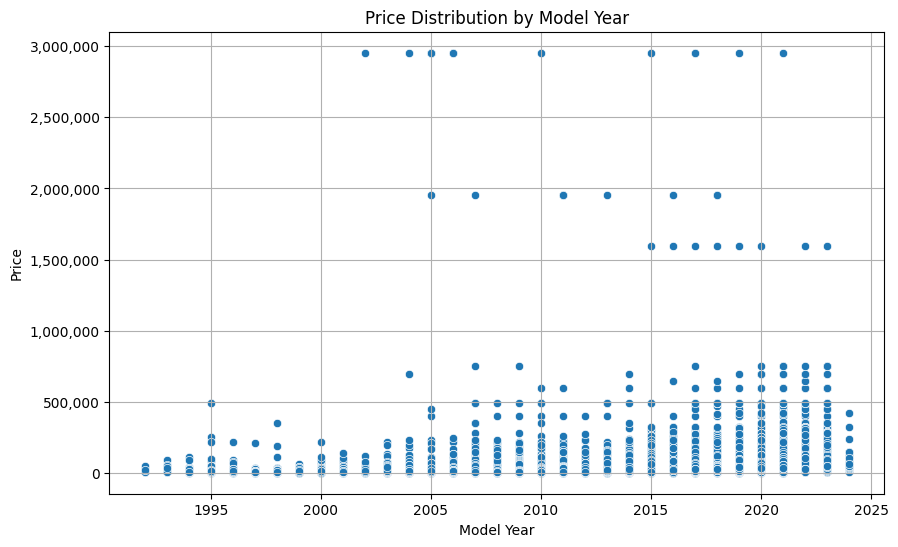

In [52]:
# New Scatterplot of model year and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model_year', y='price', data=train)

# Function to format y-axis without scientific notation
def custom_format(x, _):
    return '{:,.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_format))

plt.title('Price Distribution by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [53]:
# From the previous scatterplot of price vs milage, the right tail end seems to be an outlier.
# Remove data from milage past 350,000.
train = train[train['milage'] <= 350000]
test = test[test['milage'] <= 350000]

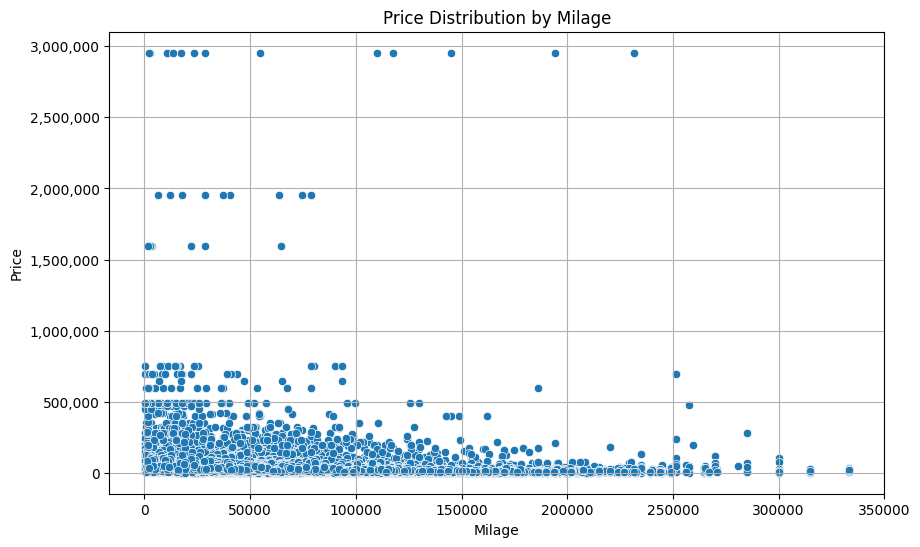

In [54]:
# New Scatterplot of Relationship of price and milage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milage', y='price', data=train)

# Function to format y-axis without scientific notation
def custom_format(x, _):
    return '{:,.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(custom_format))

plt.title('Price Distribution by Milage')
plt.xlabel('Milage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## Feature Engineering

I add an unknown category in training set for handling new brands found in testing dataset.

In [55]:
# Brand column
# Add an 'Unknown' category in the training set for handling new brands
train['brand'] = train['brand'].astype('category')
train['brand'] = train['brand'].cat.add_categories('Unknown')

# Encode 'brand' using OneHotEncoder with the new category
encoder_brand = OneHotEncoder(handle_unknown='ignore')
encoder_brand.fit(train[['brand']])

# Transform both training and test sets
train_encoded_brand = encoder_brand.transform(train[['brand']])
test['brand'] = test['brand'].apply(lambda x: x if x in train_brands else 'Unknown')
test_encoded_brand = encoder_brand.transform(test[['brand']])

In [56]:
# Check if Unknown category added
#train['brand'].value_counts()

There are lots of models in the test dataset not found in the train dataset. I will add 'other' category in the training set for handling new models.

In [57]:
# Model column
# Add an 'Other' category in the training set for handling new models
train['model'] = train['model'].astype('category')
train['model'] = train['model'].cat.add_categories('Other')

# Encode 'model' using OneHotEncoder with the new category
encoder_model = OneHotEncoder(handle_unknown='ignore')
encoder_model.fit(train[['model']])

# Transform both training and test sets
train_encoded_model = encoder_model.transform(train[['model']])
test['model'] = test['model'].apply(lambda x: x if x in train_models else 'Other')
test_encoded_model = encoder_model.transform(test[['model']])

In [58]:
# Check if Other category added
#train['model'].value_counts()

I replace - and not supported as electric for fuel_type.

In [59]:
# Fuel_type column
replacement_map = {'–': 'electric', 'not supported': 'electric'}

train['fuel_type'] = train['fuel_type'].replace(replacement_map)
test['fuel_type'] = test['fuel_type'].replace(replacement_map)

In [60]:
# Check if replaced
#train['fuel_type'].value_counts()

In [61]:
# Encode Fuel type
encoder_fuel_type = OneHotEncoder(handle_unknown='ignore')

# Fit data
encoder_fuel_type.fit(train[['fuel_type']])

# Transform both training and test sets
train_encoded_fuel_type = encoder_fuel_type.transform(train[['fuel_type']])
test['fuel_type'] = test['fuel_type'].apply(lambda x: x if x in encoder_fuel_type.categories_[0] else 'Other')
test_encoded_fuel_type = encoder_fuel_type.transform(test[['fuel_type']])

In [62]:
# Encode Transmission
encoder_transmission = OneHotEncoder(handle_unknown='ignore')

# Fit and transform training data
train_encoded_transmission = encoder_transmission.fit_transform(train[['transmission']])

# Transform test data
test['transmission'] = test['transmission'].apply(lambda x: x if x in encoder_transmission.categories_[0] else 'Other')
test_encoded_transmission = encoder_transmission.transform(test[['transmission']])

In [63]:
# Encode Accident
encoder_accident = OneHotEncoder(handle_unknown='ignore')

# Fit and transform training data
train_encoded_accident = encoder_accident.fit_transform(train[['accident']])

# Transform test data
test['accident'] = test['accident'].apply(lambda x: x if x in encoder_accident.categories_[0] else 'Other')
test_encoded_accident = encoder_accident.transform(test[['accident']])

I extract three possible features from the 'engine' column: horsepower(HP), engine displacement(L), and cylinders(Cylinder). 

I also convert from categorical to int dtype because they are quantitative.

In [64]:
# Engine column
# Function to extract numerical features
def extract_numerical_features(text):
    # horsepower
    hp_pattern = r'(\d+\.\d+)HP'   
    
    # engine_displacement
    displacement_pattern = r'(\d+\.\d+)L' 
    
    # cylinder
    cylinder_pattern = r'\b(\d+)\b Cylinder'
    
    # Initialize variables to store extracted values
    hp = None
    displacement = None
    cylinder = None
    
    # Extract values
    hp_match = re.search(hp_pattern, text)
    if hp_match:
        hp = hp_match.group(1)

    displacement_match = re.search(displacement_pattern, text)
    if displacement_match:
        displacement = displacement_match.group(1)

    cylinder_match = re.search(cylinder_pattern, text)
    if cylinder_match:
        cylinder = cylinder_match.group(1)

    return pd.Series({'horsepower': hp, 'engine_displacement': displacement, 'cylinder': cylinder})

In [65]:
# Apply extraction function and convert to numeric dtype for train dataset
extracted_features_train = train['engine'].apply(extract_numerical_features)
extracted_features_train = extracted_features_train.apply(pd.to_numeric, errors='coerce')
train = pd.concat([train, extracted_features_train], axis=1)

# Apply extraction function and convert to numeric dtype for test dataset
extracted_features_test = test['engine'].apply(extract_numerical_features)
extracted_features_test = extracted_features_test.apply(pd.to_numeric, errors='coerce')
test = pd.concat([test, extracted_features_test], axis=1)

In [66]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,accident,price,horsepower,engine_displacement,cylinder
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,None reported,11000,375.0,3.5,NaN
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,None reported,8250,300.0,3.0,6.0
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,None reported,15000,300.0,4.2,8.0
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,None reported,63500,335.0,3.0,6.0
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,7850,200.0,3.8,NaN


In [67]:
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,accident,horsepower,engine_displacement,cylinder
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,None reported,302.0,3.5,NaN
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,None reported,275.0,3.5,NaN
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,None reported,241.0,2.0,4.0
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,At least 1 accident or damage reported,518.0,5.0,8.0
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,At least 1 accident or damage reported,335.0,3.0,6.0


In [68]:
# Drop engine column
train.drop(columns=['engine'], inplace=True)
test.drop(columns=['engine'], inplace=True)

In [69]:
# Check missing ratio
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
cylinder,37.123111
horsepower,7.467748
engine_displacement,1.107630


In [70]:
train['horsepower'].value_counts()

horsepower
300.0    2619
335.0    1405
355.0    1371
240.0    1311
420.0    1235
         ... 
691.0       1
341.0       1
533.0       1
111.0       1
422.0       1
Name: count, Length: 341, dtype: int64

In [71]:
# Check missing values
train['horsepower'].isnull().sum()

4052

In [72]:
test['horsepower'].isnull().sum()

2605

There is 4052 missing values in horsepower in the training data set. I will replace missing data with the mean of horsepower by model. I will also replace the missing values in the test dataset

In [73]:
train['horsepower'] = train.groupby('model')['horsepower'].transform(lambda x: x.fillna(x.mean()))
test['horsepower'] = test.groupby('model')['horsepower'].transform(lambda x: x.fillna(x.mean()))

In [74]:
# Check missing values
train['horsepower'].isnull().sum()

486

In [75]:
test['horsepower'].isnull().sum()

450

There is still missing values, I will fill the rest with the average mean of horsepower for convenience. For further accuracy, research on information specific to model, make, and year to determine horsepower could be done. 

In [76]:
mean_train_horsepower = train['horsepower'].mean()
mean_test_horsepower = test['horsepower'].mean()

train['horsepower'] = train['horsepower'].fillna(mean_train_horsepower)
test['horsepower'] = test['horsepower'].fillna(mean_test_horsepower)

In [77]:
train['horsepower'].isnull().sum()

0

In [78]:
test['horsepower'].isnull().sum()

0

In [79]:
# Check missing values
train['engine_displacement'].isnull().sum()

601

In [80]:
test['engine_displacement'].isnull().sum()

404

In [81]:
train['engine_displacement'] = train.groupby('model')['engine_displacement'].transform(lambda x: x.fillna(x.mean()))

test['engine_displacement'] = test.groupby('model')['engine_displacement'].transform(lambda x: x.fillna(x.mean()))

In [82]:
# Check missing values
train['engine_displacement'].isnull().sum()

257

In [83]:
test['engine_displacement'].isnull().sum()

183

In [84]:
# Replace missing data with mean
mean_train_displacement = train['engine_displacement'].mean()
mean_test_displacement = test['engine_displacement'].mean()

train['engine_displacement'] = train['engine_displacement'].fillna(mean_train_displacement)
test['engine_displacement'] = test['engine_displacement'].fillna(mean_test_displacement)

In [85]:
# Check missing values
train['engine_displacement'].isnull().sum()

0

In [86]:
test['engine_displacement'].isnull().sum()

0

In [87]:
train['cylinder'].isnull().sum()

20143

In [88]:
test['cylinder'].isnull().sum()

13279

There is a lot of missing data in cylinder. I will fill the null with average value within same model group. Because electric cars do not have cylinders, we will set engine cylinder to 0 if fuel_type is electric.

In [89]:
# fill the null with similiar value in model
train['cylinder'] = train.groupby('model')['cylinder'].transform(lambda x: x.fillna(x.mean()))
test['cylinder'] = test.groupby('model')['cylinder'].transform(lambda x: x.fillna(x.mean()))

In [90]:
# Check missing values
train['cylinder'].isnull().sum()

7607

In [91]:
test['cylinder'].isnull().sum()

6327

In [92]:
# If fuel_type is electric, set cylinder to 0.
train.loc[(train['cylinder'].isna()) & (train['fuel_type'] == 'electric'), 
       'cylinder'] = 0

In [93]:
test.loc[(train['cylinder'].isna()) & (test['fuel_type'] == 'electric'), 
       'cylinder'] = 0

In [94]:
# Check missing values
train['cylinder'].isnull().sum()

7497

In [95]:
test['cylinder'].isnull().sum()

6315

In [96]:
# Replace missing data with mean
mean_train_cyl = train['cylinder'].mean()
mean_test_cyl = test['cylinder'].mean()

train['cylinder'] = train['cylinder'].fillna(mean_train_cyl)
test['cylinder'] = test['cylinder'].fillna(mean_test_cyl)

In [97]:
# Check missing values
train['cylinder'].isnull().sum()

0

In [98]:
test['cylinder'].isnull().sum()

# Check entire dataframe for missing values
train.isnull().sum()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
transmission           0
accident               0
price                  0
horsepower             0
engine_displacement    0
cylinder               0
dtype: int64

In [99]:
test.isnull().sum()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
transmission           0
accident               0
horsepower             0
engine_displacement    0
cylinder               0
dtype: int64

Because we encoded on multiple data sets, we need to align the train and test data accordingly.

In [100]:
# Align test data with each encoder's columns using hstack
def align_sparse_matrices(test_encoded, train_encoded):
    if test_encoded.shape[1] < train_encoded.shape[1]:
        # Pad test_encoded with zeros
        num_cols_to_add = train_encoded.shape[1] - test_encoded.shape[1]
        padding = csr_matrix((test_encoded.shape[0], num_cols_to_add))
        return hstack([test_encoded, padding])
    else:
        return test_encoded

# Align each encoded test data with corresponding training data
test_encoded_brand_aligned = align_sparse_matrices(test_encoded_brand, train_encoded_brand)
test_encoded_model_aligned = align_sparse_matrices(test_encoded_model, train_encoded_model)
test_encoded_fuel_type_aligned = align_sparse_matrices(test_encoded_fuel_type, train_encoded_fuel_type)
test_encoded_transmission_aligned = align_sparse_matrices(test_encoded_transmission, train_encoded_transmission)
test_encoded_accident_aligned = align_sparse_matrices(test_encoded_accident, train_encoded_accident)

# Convert aligned matrices back to DataFrames if needed
test_encoded_brand_df = pd.DataFrame.sparse.from_spmatrix(test_encoded_brand_aligned)
test_encoded_model_df = pd.DataFrame.sparse.from_spmatrix(test_encoded_model_aligned)
test_encoded_fuel_type_df = pd.DataFrame.sparse.from_spmatrix(test_encoded_fuel_type_aligned)
test_encoded_transmission_df = pd.DataFrame.sparse.from_spmatrix(test_encoded_transmission_aligned)
test_encoded_accident_df = pd.DataFrame.sparse.from_spmatrix(test_encoded_accident_aligned)

# Concatenate encoded test data frames
test_encoded_df = pd.concat([
    test_encoded_brand_df,
    test_encoded_model_df,
    test_encoded_fuel_type_df,
    test_encoded_transmission_df,
    test_encoded_accident_df
], axis=1)


In [101]:
# Drop all original categorical columns after encoding for train data

# Drop Brand column after encoding
train.drop(['brand'], axis = 1, inplace = True)

# Drop Model column after encoding
train.drop(['model'], axis = 1, inplace = True)

# Drop Fuel Type column after encoding
train.drop(['fuel_type'], axis = 1, inplace = True)

# Drop Transmission column after encoding
train.drop(['transmission'], axis = 1, inplace = True)

# Drop Accident column after encoding
train.drop(['accident'], axis = 1, inplace = True)

In [102]:
# Drop Brand column after encoding for test data
test.drop(['brand'], axis = 1, inplace = True)

# Drop Model column after encoding
test.drop(['model'], axis = 1, inplace = True)

# Drop Fuel Type column after encoding
test.drop(['fuel_type'], axis = 1, inplace = True)

# Drop Transmission column after encoding
test.drop(['transmission'], axis = 1, inplace = True)

# Drop Accident column after encoding
test.drop(['accident'], axis = 1, inplace = True)

In the case that the dummy creation would be different in train and test data sets, I fill in all missing columns with 0s.

In [103]:
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test[train.columns]

## Prepare Model
First I split the data into features and target variable from the train and test dataset.

In [104]:
# Split data into features and target
X_train = train.drop('price', axis=1)  # features from train data
y_train = train['price']               # target from train data

X_test = test.drop('price', axis=1)    # features from test data
y_test = test['price']                 # target from test data

In [105]:
# Set seed
np.random.seed(123)

## Fit and transform model
Next I scale the data to fit and transform the model to normalize data, which ensures all features contribute equally by converting them to a common scale.

In [106]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Predictions

In [107]:
y_train_pred = lm_model.predict(X_train_scaled)
y_test_pred = lm_model.predict(X_test_scaled)

NameError: name 'lm_model' is not defined

# Train Model
I train the data on several different models and compare results

## Linear Regression

In [ ]:
# Linear Regression model
lm_model = LinearRegression()
lm_model.fit(X_train_scaled, y_train)

# Predict
y_train_pred = lm_model.predict(X_train_scaled)
y_test_pred = lm_model.predict(X_test_scaled)

# Evaluate 
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSE - Training Set: {rmse_train}')
print(f'RMSE - Test Set: {rmse_test}')

## Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled, y_train)

# Predict
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Evaluate
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSE - Training Set: {rmse_train}')
print(f'RMSE - Test Set: {rmse_test}')

## Random Forest 

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Evaluate
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSE - Training Set: {rmse_train}')
print(f'RMSE - Test Set: {rmse_test}')

## Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train_scaled, y_train)

# Predict
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

# Evaluate
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSE - Training Set: {rmse_train}')
print(f'RMSE - Test Set: {rmse_test}')

## Neural Network

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Predict
y_train_pred = mlp.predict(X_train_scaled)
y_test_pred = mlp.predict(X_test_scaled)

# Evaluate
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'RMSE - Training Set: {rmse_train}')
print(f'RMSE - Test Set: {rmse_test}')

## Catboost

In [ ]:
params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
}

catboost = CatBoostRegressor(**params)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)


# Evaluate Model

# Hyperparameter Tuning and Optimization

# Predictions 